<a href="https://colab.research.google.com/github/jatinm17/SHL_Assessment/blob/main/Grammer_Score_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Objective
The goal is to build a machine learning model that automatically evaluates a speaker's **English grammar proficiency** from spoken audio. Each audio sample is scored between 0 and 5, and the task is a **regression problem**.

---

## Dataset Description
- **Audio files**: `.wav` format (45–60 seconds each).
- **train.csv**: Contains file names and grammar scores (labels).
- **test.csv**: Contains file names without labels.
- **sample_submission.csv**: Required format for final output.

---

##  Overall Pipeline
1. Load audio data and corresponding CSVs.
2. Extract features using both deep and traditional audio methods.
3. Train regression models to predict grammar scores.
4. Optimize model performance via GridSearchCV.
5. Evaluate models using regression metrics.
6. Make predictions on test set and prepare submission file.

---

##  Feature Extraction
### 1. Wav2Vec2 Embeddings
- A pretrained transformer model from Facebook for speech.
- Extracts high-level audio representations.
- Captures phonetic and grammatical information.

### 2. Librosa Audio Features
- **MFCCs**: Capture timbre and phonetic structure.
- **ZCR (Zero Crossing Rate)**: Indicates noisiness.
- **Spectral Centroid & Bandwidth**: Represent audio brightness and spread.


---

##  Data Preparation
- Features are extracted for all audio files in training data.
- Data is split into training and validation sets (e.g., 80/20).
- Feature vectors are used as inputs, and scores are targets.

---

##  Models Used
###  1. Random Forest Regressor
- An ensemble of decision trees.
- Handles non-linear relationships.
- Tuned using GridSearchCV for best depth, estimators, and features.

### 2. LightGBM Regressor
- Fast and memory-efficient gradient boosting.
- Suitable for large and high-dimensional features.
- Tuned using learning rate, leaves, depth, and subsampling.

### 3. XGBoost Regressor

- Gradient-boosted decision trees.
- Learns from residuals to minimize error.
- GridSearchCV used to optimize parameters like learning rate, max depth.

---

## Evaluation Metrics
Models are evaluated on the validation set using:
- **MAE (Mean Absolute Error)**: Measures average error.
- **RMSE (Root Mean Squared Error)**: Penalizes larger errors more heavily.
- **R² Score**: Indicates how well predictions fit actual scores.

---

##  Model Selection
- Compare models based on MAE, RMSE, and R².
- Select the one that provides the **best trade-off**.
- Random Forest and LightGBM are all evaluated.

---

## Submission Generation
- Extract features from test audio files using the same pipeline.
- Make predictions using the best model.
- Generate a CSV file (`file_name`, `label`) for submission.

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install Required Libraries
!pip install transformers librosa


In [102]:
#  Import Required Libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


In [103]:
# Load CSVs Files and Set Paths
base_path = '/content/drive/MyDrive/shl-intern-hiring-assessment/dataset'
train_df = pd.read_csv(f'{base_path}/train.csv')
test_df = pd.read_csv(f'{base_path}/test.csv')
sample_submission = pd.read_csv(f'{base_path}/sample_submission.csv')
train_df.head()


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


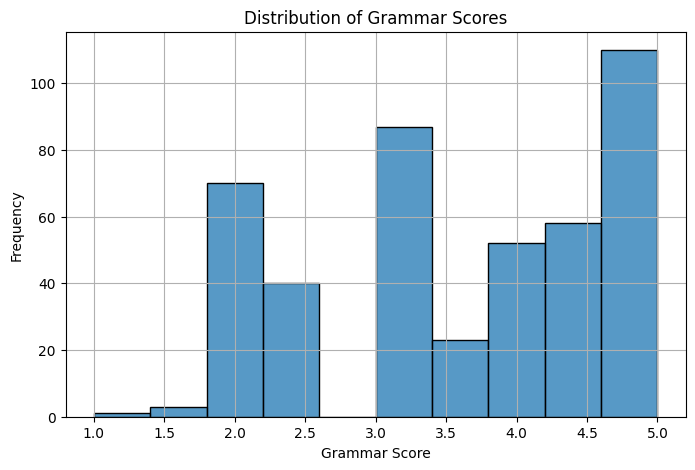

In [104]:
#  Grammar Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(train_df['label'], bins=10)
plt.title("Distribution of Grammar Scores")
plt.xlabel("Grammar Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Duration: 60.07 seconds


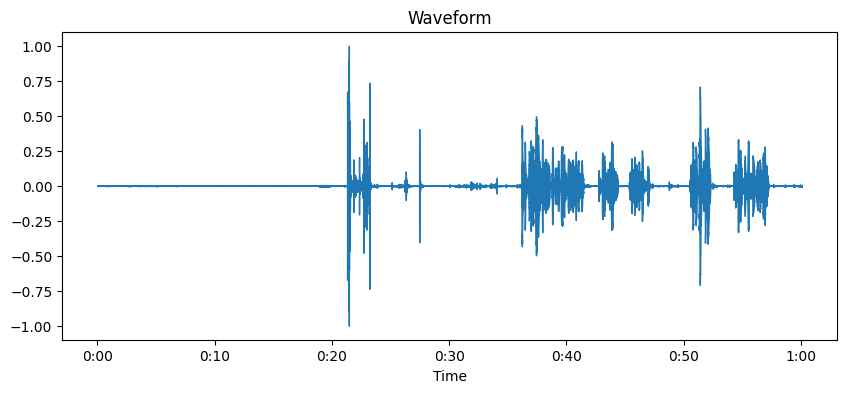

In [105]:
#  Visualize a Sample Audio
file_path = f"{base_path}/audios_train/" + train_df.iloc[0]['filename']
y, sr = librosa.load(file_path, sr=16000)
print(f"Duration: {len(y)/sr:.2f} seconds")

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()


In [106]:
# Using a Pretrained Model for Feature Extraction
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)



Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
# Setting a path for audio directories
train_audio_dir = "/content/drive/MyDrive/shl-intern-hiring-assessment/dataset/audios_train"
test_audio_dir = "/content/drive/MyDrive/shl-intern-hiring-assessment/dataset/audios_test"

**Feature Extraction**

In [108]:
# Extraction all the necessary features
def extract_combined_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)

    # Wav2Vec2 embedding
    inputs = processor(y, sampling_rate=sr, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = wav2vec_model(**{k: v.to(device) for k, v in inputs.items()})
    wav2vec_embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

    # Librosa features
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    return np.concatenate([wav2vec_embedding, [zcr, centroid, bandwidth], mfccs])


In [110]:
X, y = [], []

for _, row in train_df.iterrows():
    file_path = os.path.join(train_audio_dir, row['filename'])
    features = extract_combined_features(file_path)
    X.append(features)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)


**Model Training**

In [111]:
# Train Regressor
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
print("🔧 Best Params:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred_best)
rmse = mean_squared_error(y_val, y_pred_best)
r2 = r2_score(y_val, y_pred_best)

print(" Tuned RF via GridSearch")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
🔧 Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
 Tuned RF via GridSearch
MAE  : 0.7944
RMSE : 0.8500
R²   : 0.3765


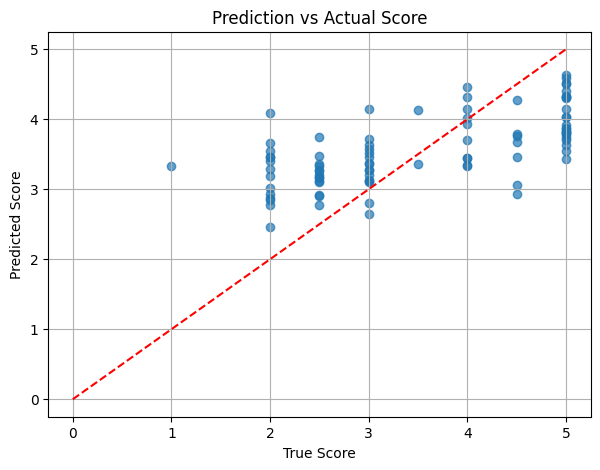

In [53]:
# Plot Actual vs Predicted Scores
plt.figure(figsize=(7, 5))
plt.scatter(y_val, y_pred_best, alpha=0.7)
plt.plot([0, 5], [0, 5], '--r')
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Prediction vs Actual Score")
plt.grid(True)
plt.show()


In [124]:
# Train LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(random_state=42)

param_grid_lgb = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 64],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}



In [27]:
grid_lgb = GridSearchCV(
    lgb_model, param_grid_lgb,
    cv=3, scoring='neg_mean_absolute_error',
    verbose=1, n_jobs=-1
)

grid_lgb.fit(X_train, y_train)
best_lgb = grid_lgb.best_estimator_


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93354
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 784
[LightGBM] [Info] Start training from score 3.635211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [28]:
y_pred_lgb = best_lgb.predict(X_val)

print(" LightGBM Results:")
print("MAE :", mean_absolute_error(y_val, y_pred_lgb))
print("RMSE:", mean_squared_error(y_val, y_pred_lgb))
print("R²  :", r2_score(y_val, y_pred_lgb))

print("\nBest Hyperparameters:")
print(grid_lgb.best_params_)


 LightGBM Results:
MAE : 0.7790379952554681
RMSE: 0.8785273037913816
R²  : 0.35551611268057126

Best Hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}


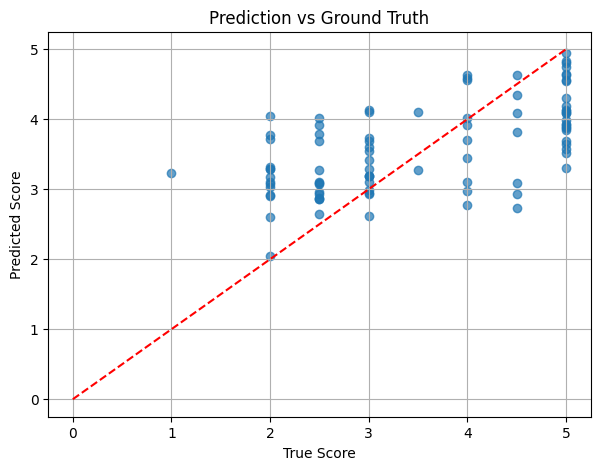

In [29]:
plt.figure(figsize=(7, 5))
plt.scatter(y_val, y_pred_lgb, alpha=0.7)
plt.plot([0, 5], [0, 5], '--r')
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Prediction vs Ground Truth")
plt.grid(True)
plt.show()

**Generating Submission File**

In [31]:
test_features = []

for file_name in test_df['filename']:
    file_path = os.path.join(test_audio_dir, file_name)
    features = extract_combined_features(file_path)
    test_features.append(features)

X_test = np.array(test_features)



In [116]:
# Predicting label using Light XGBOOST model
test_preds = best_lgb.predict(X_test)
test_preds = np.round(test_preds, 1)

In [69]:
submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_preds
})

submission.to_csv("submission.csv", index=False)

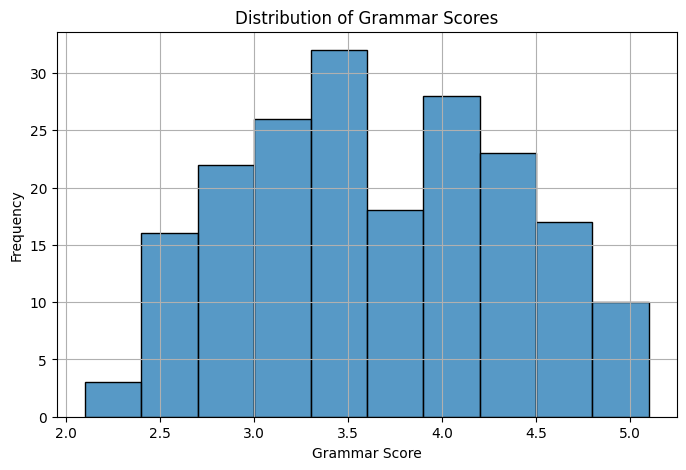

In [70]:
plt.figure(figsize=(8, 5))
sns.histplot(submission['label'], bins=10)
plt.title("Distribution of Grammar Scores")
plt.xlabel("Grammar Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**XGBOOST Model**

In [113]:
from xgboost import XGBRegressor
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid = GridSearchCV(xgb, param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)

print("⚡ XGBoost:")
print("MAE :", mean_absolute_error(y_val, y_pred_xgb))
print("RMSE:", mean_squared_error(y_val, y_pred_xgb))
print("R²  :", r2_score(y_val, y_pred_xgb))


Fitting 3 folds for each of 32 candidates, totalling 96 fits
⚡ XGBoost:
MAE : 0.7379705209410592
RMSE: 0.7700610084589199
R²  : 0.43508652484342647


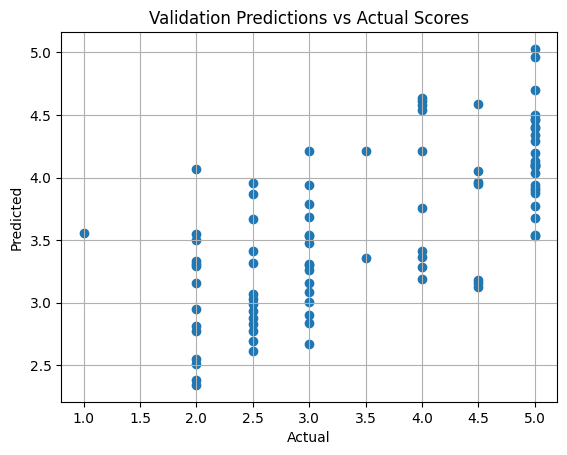

In [122]:
import matplotlib.pyplot as plt

plt.scatter(y_val, y_pred_xgb)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Validation Predictions vs Actual Scores")
plt.grid(True)
plt.show()


In [120]:
# Predicting label using XGBOOST model
test_preds = best_xgb.predict(X_test)
test_preds = np.round(test_preds, 1)

**Submission File**

In [118]:
submission_df = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_preds
})

submission_df.to_csv("submission_final.csv", index=False)

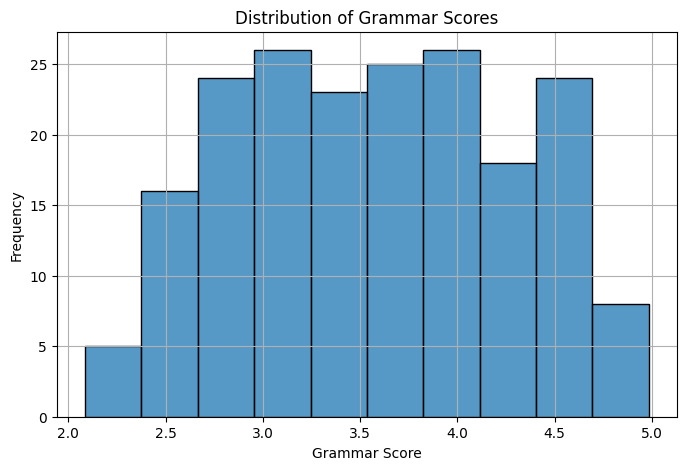

In [123]:
plt.figure(figsize=(8, 5))
sns.histplot(submission_df['label'], bins=10)
plt.title("Distribution of Grammar Scores")
plt.xlabel("Grammar Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()